In [17]:
import cv2
import numpy as np
import random
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Character-to-index mapping for digits 0-9 and letters A-Z
chars = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
char_to_index = {char: idx for idx, char in enumerate(chars)}


def generate_training_data(chars='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ', num_samples=100, output_dir='training_data'):
    """Generate synthetic images of characters 0-9 and A-Z with random padding, rotation, and noise."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    images = []
    labels = []
    
    for char in chars:
        for i in range(num_samples):
            # Create a blank image (28x28)
            img = np.zeros((28, 28), dtype=np.uint8)
            
            # Apply random padding (max 5 pixels)
            top_padding = random.randint(0, 5)
            bottom_padding = random.randint(0, 5)
            left_padding = random.randint(0, 5)
            right_padding = random.randint(0, 5)
            
            # Ensure padding does not exceed image dimensions
            img = cv2.copyMakeBorder(img, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=(0))
            
            # Draw the character on the padded image
            font = cv2.FONT_HERSHEY_SIMPLEX
            char_size = cv2.getTextSize(char, font, 1, 2)[0]
            
            # Ensure y position is within a valid range
            y_min = char_size[1] + 5  # Minimum y position (to avoid text being cut off)
            y_max = img.shape[0] - 5  # Maximum y position (to avoid text going out of bounds)
            y = random.randint(0, 20)
            
            # Ensure x position doesn't cause the text to go out of bounds
            x = random.randint(5, 20)
            
            cv2.putText(img, char, (x, y), font, 1, (255,), 2, cv2.LINE_AA)
            
            # Apply random rotation
            angle = random.randint(-10, 10)  # Rotate between -10 and 10 degrees
            M = cv2.getRotationMatrix2D((img.shape[1] // 2, img.shape[0] // 2), angle, 1)
            img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
            
            # Apply random noise
            noise = np.random.normal(0, 10, img.shape)  # Gaussian noise
            img = np.clip(img + noise, 0, 255).astype(np.uint8)
            
            # Resize image to 28x28 to ensure uniform size
            img_resized = cv2.resize(img, (28, 28))
            
            # Save the generated image to a file with the character label
            output_filename = os.path.join(output_dir, f"{char}_{i}.png")
            cv2.imwrite(output_filename, img_resized)
            
            # Flatten and add to the dataset
            images.append(img_resized)
            labels.append(char_to_index[char])  # Store the corresponding numeric label
    
    # Convert to numpy arrays
    images = np.array(images).reshape(-1, 28, 28, 1).astype('float32') / 255.0  # Normalize
    labels = np.array(labels)
    labels = to_categorical(labels, num_classes=len(chars))  # One-hot encode labels
    
    return images, labels



# Step 2: Build the OCR model using CNN
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(chars), activation='softmax')  # Output layer for 36 classes
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 3: Train the model
def train_model(model, images, labels):
    model.fit(images, labels, epochs=20, batch_size=16)

# Step 4: Predict characters from a generated image
def predict(model, img):
    img = img.reshape(1, 28, 28, 1).astype('float32') / 255.0  # Normalize the image
    prediction = model.predict(img)
    predicted_char_index = np.argmax(prediction)
    predicted_char = chars[predicted_char_index]
    return predicted_char

# Generate training data for digits 0-9 and letters A-Z with added complexity
images, labels = generate_training_data(chars='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ', num_samples=100)

# Build and train the model
model = build_model()
train_model(model, images, labels)

# Now, let's generate an image with 3 random characters (digits or letters) and test the OCR
def generate_image_with_digits(chars='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ', output_dir='generated_images'):
    """Generate an image with 3 random characters with padding and rotation, then save the image to a file."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    img = np.zeros((28, 84), dtype=np.uint8)  # Image width is enough for 3 characters
    
    chars_to_predict = random.choices(chars, k=3)
    x = 5  # Initial x position for the first character
    for char in chars_to_predict:
        font = cv2.FONT_HERSHEY_SIMPLEX
        char_size = cv2.getTextSize(char, font, 1, 2)[0]
        y = random.randint(char_size[1], 24)  # Random vertical position
        
        cv2.putText(img, char, (x, y), font, 1, (255,), 2, cv2.LINE_AA)
        x += 28  # Move x for the next character
    
    # Apply random padding to the whole image
    img = cv2.copyMakeBorder(img, random.randint(0, 5), random.randint(0, 5), random.randint(0, 5), random.randint(0, 5), cv2.BORDER_CONSTANT, value=(0))
    
    # Apply random rotation
    angle = random.randint(-10, 10)
    M = cv2.getRotationMatrix2D((img.shape[1] // 2, img.shape[0] // 2), angle, 1)
    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    
    # Save the generated image with its character label
    image_label = ''.join(chars_to_predict)
    output_filename = os.path.join(output_dir, f"{image_label}.png")
    cv2.imwrite(output_filename, img)
    
    return img, image_label

# Generate and save an image with 3 characters
img, original_chars = generate_image_with_digits()

# Predict each character in the generated image
predicted_chars = []
for i in range(3):
    char_img = img[:, i*28:(i+1)*28]  # Extract each character's 28x28 part
    char_img = cv2.resize(char_img, (28, 28))  # Resize each character if needed
    predicted_char = predict(model, char_img)
    predicted_chars.append(predicted_char)

# Print the results
print(f"Original Characters: {original_chars}")
print(f"Predicted Characters: {''.join(predicted_chars)}")


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0461 - loss: 3.5299
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2202 - loss: 2.5812
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4037 - loss: 1.8426
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5213 - loss: 1.4828
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5650 - loss: 1.2947
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5997 - loss: 1.1943
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6384 - loss: 1.0730
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6579 - loss: 0.9866
Epoch 9/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6691 - loss: 0.9492
Epoch 10/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6950 - loss: 0.8721
Epoch 11/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7102 - loss: 0.8380
Epoch 12/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Build a simple neural network
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=25)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# Make predictions
predictions = model.predict(x_test)

# Show the first prediction
print(f"Prediction: {np.argmax(predictions[0])}")
plt.imshow(x_test[0], cmap=plt.cm.binary)
plt.show()

model.save('mnist_model.hadi.keras')


Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8542 - loss: 0.4926
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9559 - loss: 0.1507
Epoch 3/25
 790/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9656 - loss: 0.1131

KeyboardInterrupt: 

In [21]:
model.save('mnist_model.hadi.keras')


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

loaded_model = tf.keras.models.load_model('mnist_model.hadi.keras')



2025-01-07 01:04:24.579511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736195664.597309    6905 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736195664.602068    6905 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 01:04:24.618556: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-07 01:04:27.715825: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Digit: 7


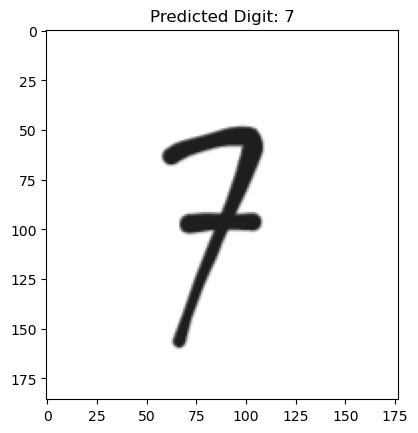

In [11]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the pretrained MNIST model (assuming you've already trained it)
model = tf.keras.models.load_model('mnist_model.hadi.keras')  # Update with your model path

# Function to preprocess the screenshot image
def preprocess_image(image_path):
    # Open the image
    img = Image.open(image_path)
    
    # Convert the image to grayscale if it's not already
    img = img.convert('L')
    
    # Resize the image to 28x28 pixels
    img = img.resize((28, 28))
    
    # Invert the image (MNIST images have white background with black digits)
    img = Image.eval(img, lambda x: 255 - x)
    
    # Convert image to numpy array and normalize pixel values (0-1)
    img_array = np.array(img) / 255.0
    
    # Reshape to match the input shape for the model (1, 28, 28, 1)
    img_array = img_array.reshape(1, 28, 28, 1)
    
    return img_array

# Function to predict the digit in the image
def predict_digit(image_path):
    # Preprocess the image
    img_array = preprocess_image(image_path)
    
    # Predict the digit
    prediction = model.predict(img_array)
    
    # Get the predicted digit (index of the highest probability)
    predicted_digit = np.argmax(prediction)
    
    return predicted_digit

# Provide the path to the screenshot you want to classify
image_path = '/home/hadi/Pictures/seven.png'  # Update with your screenshot path

# Predict the digit in the image
predicted_digit = predict_digit(image_path)
print(f"Predicted Digit: {predicted_digit}")

# Display the image
img = Image.open(image_path)
plt.imshow(img, cmap=plt.cm.binary)
plt.title(f"Predicted Digit: {predicted_digit}")
plt.show()
